**DATA 100 FINAL PROJECT**

**Dateset used: COVID-19**

**Project Description:** 
*The following project builds a linear regression model to predict the number of deaths, confirmed cases and hospitalisations regarding COVID-19 patients in New York to ultimately determine the required number of hospital beds. All helper functions can be referenced in the third cell. Data is mostly directly imported from github, save for data on hospital beds. Data mostly the same as what was provided save updates made to the links cited.*

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline
plt.style.use('seaborn')
import matplotlib.colors as mcolors
import random
import math
import time
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
import sklearn
import sklearn.datasets
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
import datetime
import operator
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import math
from scipy.optimize import curve_fit
from sklearn import preprocessing

# Folium may take a moment to install
!conda --debug install -y -c conda-forge folium
!pip install folium
import folium 
from folium import plugins

# Manipulating the default plot size
plt.rcParams['figure.figsize'] = 10, 6

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/bin/bash: conda: command not found


In [0]:
# Load datasets from accomapnyign files.

# Dataset provided is till 4/18/2020. Contains 
# demographic, socioeconomic, health care, education and transit data for each 
# county in the 50 states and Washington DC.
counties = pd.read_csv('abridged_counties.csv')

# Dataset provided is till 4/06/2020. Contains timeseries
# of confirmed COVID-19 cases in the US.
confirmed_us = pd.read_csv('time_series_covid19_confirmed_US.txt')

# Dataset provided is till 4/06/2020. Contains timeseries
# of confirmed COVID-19 cases in the world.
confirmed_global = pd.read_csv('time_series_covid19_confirmed_global.txt')

# Dataset provided is till 4/06/2020. Contains timeseries
# of confirmed COVID-19 deaths in the US.
deaths_us = pd.read_csv('time_series_covid19_deaths_US.txt')

# Dataset provided is till 4/06/2020. Contains timeseries
# of confirmed COVID-19 deaths in the world.
deaths_global = pd.read_csv('time_series_covid19_deaths_global.txt')

# Dataset provided is till 4/06/2020. Contains timeseries
# of confirmed COVID-19 recoveries in the world.
recovered_global = pd.read_csv('time_series_covid19_recovered_global.txt')

# Dataset provided is till 4/06/2020.
# Contains state level data of COVID-19 cases in the US and associated rates.
states = pd.read_csv('states.txt')

# Dataset procured from http://www.healthdata.org/covid/data-downloads. Contains
# total hospital bed data at state level.
hospital_beds = pd.read_csv('https://raw.githubusercontent.com/AyelaChughtai/FinalProject/master/summary_stats_all_locs.csv')


In [0]:
# Some helper functions used often for cleaning.

states_list = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 
          'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 
          'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
          'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
          'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
          'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
          'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
          'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 
          'Wisconsin', 'Wyoming']

state_abbrev = {'AL': 'Alabama', 'AK': 'Alaska','AZ': 'Arizona','AR': 'Arkansas',
          'CA' : 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
          'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana',
          'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
          'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
          'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
          'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota',
          'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania',
          'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee',
          'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia',
          'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

def assign_states(df, statenames, states):
    """ For states with only abbreviation, fill in missing names. """
    for i in range(len(df[statenames])):
        if not (df[states][i] in states_list):
            df[states][i] = state_abbrev.get(df[statenames][i])

def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def remove_rows(df, column, row):
    """Select all but these rows from the dataframe."""
    return df[df.pipe(lambda x: x[column] != row)]

def select_rows(df, column, row):
    """Select these rows from the dataframe."""
    return df[df.pipe(lambda x: x[column] == row)]

def columns_list(data):
    """ Returns list of columns in table. """
    return data.columns.tolist()

def clean_timeseries(df, id, value, columns):
    """ Cleans world timeseries COVID-19 data. 
    Variables: value -'Confirmed' or 'Death', 
    id - columns to identify for melting table. """
    df = df.drop(columns, axis = 1).groupby(id).sum().reset_index()
    melted = pd.melt(df, id_vars = [id], 
    var_name = "Date", value_name = value)
    return melted
  
def null_count(data):
    """ Returns a series containing number of null value occurrences per
    column in a dataframe. """
    return data.isna().sum()

def null_sum(data):
    """ Returns total number of null value in a dataframe. """
    return data.isna().sum().sum()

def format_dates(df, columns):
    """ Turns time data to time stamps. """
    for column in columns:
        df[column] = df[column].apply(int).apply(dt.datetime.fromordinal)
    return df

def days_since(df, columns):
    """ Returns value for days since 01/22/2000. """
    for column in columns:
        date1 = pd.Timestamp('20200122 00:00:00')
        for i in range(len(df[column])):
            df[column][i] = (df[column][i] - date1).days
    return df

def rmse(predicted, actual):
    """ Computes the RMSE between predicted and actual y-values. """
    return np.sqrt(np.mean((actual - predicted) ** 2))

In [0]:
# First, we looked at state data and cleaned the data set by dropping columns
# we didn't use and renaming others. For the entire model we will assume that
# the data present in above files is accurate.

states = states.drop(columns = ['Last_Update', 'FIPS', 'Lat', 'Long_', 'UID', 
        'Country_Region', 'ISO3']).rename(columns = {'Province_State': 'State'})

In [0]:
# We will focus on cleaning the data by dropping unnecessary rows like 'Diamond Princess', which
# are not states. We will thus narrow down our data to the 50 states specified in
# the following list and exclude ships/territories.

for state in list(states['State']):
    if not (state in states_list):
        states = remove_rows(states, 'State', state)

states = states.reset_index(drop = True)

In [6]:
# Instead of removing NaN values, we first check see where they are coming from.

print(null_count(states))

State                    0
Confirmed                0
Deaths                   0
Recovered               13
Active                   0
Incident_Rate            0
People_Tested            0
People_Hospitalized     18
Mortality_Rate           0
Testing_Rate             0
Hospitalization_Rate    18
dtype: int64


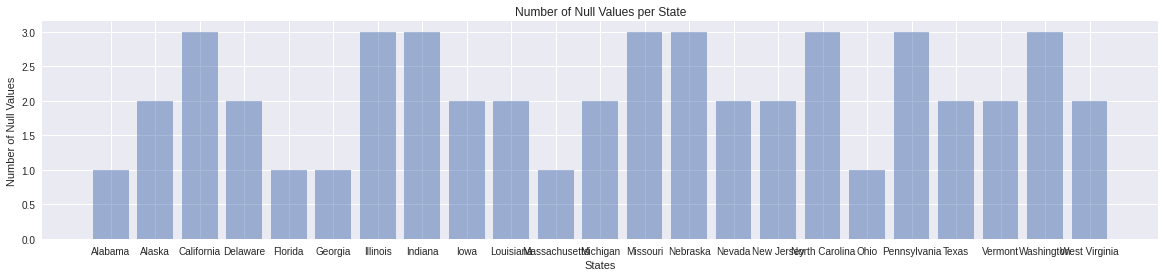

In [7]:
# Almost all the null values of the states dataframe come from missing data
# on recovery and hospitalisation. We will now see which states these are coming from.

null_states = []
null_counts = []

for state in list(states['State']):
    nulls = null_sum(select_rows(states, 'State', state))
    if nulls > 0:
        null_states.append(state)
        null_counts.append(nulls)

y_pos = np.arange(len(null_states))
plt.figure(figsize = (20, 4))
plt.bar(y_pos, null_counts, align = 'center', alpha = 0.5)
plt.xticks(y_pos, null_states)
plt.ylabel('Number of Null Values')
plt.xlabel('States')
plt.title('Number of Null Values per State')
plt.show()

In [8]:
# We will now fill the null values through interpolation to get a reasonable 
# estimate of people hospitalised. To get the number of recoveries we simply
# subtract deaths and active cases from confirmed cases. We will also visualise the 
# highest rates for the columns. It is noteworthy that despite having the highest 
# number of cases, NY's hospitalisation rate is less than Kentucky's. 
# It would be interesting to look at hospital data and check whether or this 
# is a capacity issue or if most detected NY cases are mild.

for i in range(len(states['State'])):
    if np.isnan(states['Recovered'][i]):
        states['Recovered'][i] = states['Confirmed'][i] - states['Active'][i] 
        - states['Deaths'][i]

states = states.interpolate()
states.style.background_gradient(cmap = 'Reds')

,State,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,Alabama,8691,343,343.000000,8348.000000,185.352760,109516.000000,1158.000000,3.946611,2335.645249,13.324128
1,Alaska,372,10,284.000000,78.000000,62.233479,23655.000000,1294.000000,2.688172,3957.346645,14.027883
2,Arizona,9707,426,1693.000000,7588.000000,133.361415,91737.000000,1430.000000,4.388586,1260.345745,14.731637
3,Arkansas,3611,87,2109.000000,1415.000000,139.473246,59003.000000,453.000000,2.409305,2278.964260,12.545001
4,California,60616,2464,2464.000000,58152.000000,154.598657,809036.000000,1686.000000,4.064933,2063.413606,14.457225
5,Colorado,17832,919,2801.000000,14112.000000,314.674227,85976.000000,2919.000000,5.153656,1517.184350,16.369448
6,Connecticut,30995,2718,4346.000000,23931.000000,869.354978,111447.000000,7758.000000,8.769156,3125.891408,25.029844
7,Delaware,5778,193,2008.000000,3577.000000,593.367592,26468.000000,7267.000000,3.340256,2718.112397,21.430242
8,Florida,38002,1539,1539.000000,36463.000000,178.979443,480051.000000,6776.000000,4.049787,2260.914181,17.830640
9,Georgia,30743,1327,1327.000000,29416.000000,303.203555,204137.000000,5765.000000,4.316430,2013.305925,18.752236


Text(0.5, 1.0, 'Spread per State')

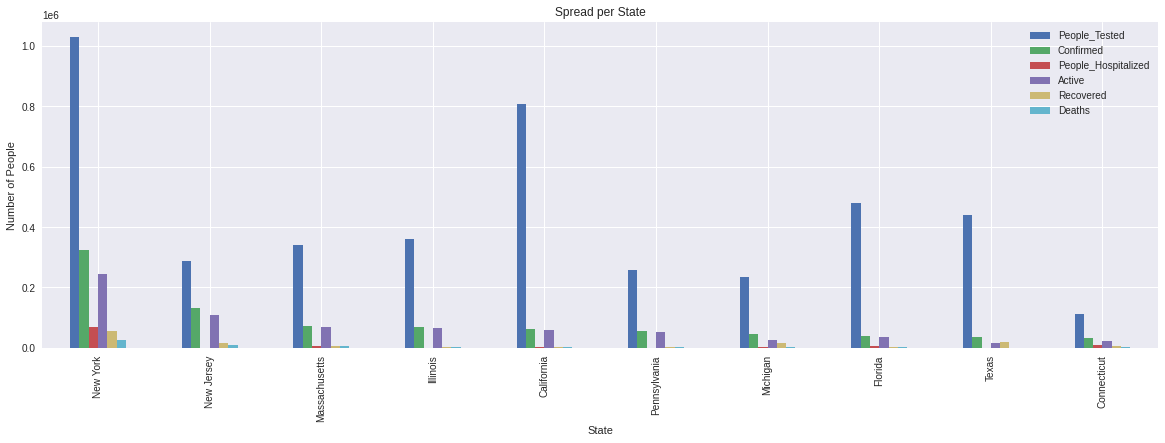

In [9]:
# The following code produces a bar chart to visualise certain traits of the 10
# states with the highest number of confirmed cases, reflecting the trends we can 
# see in the above table.

states.sort_values('Confirmed', ascending = False).head(10)[['State', 
'People_Tested', 'Confirmed', 'People_Hospitalized', 'Active', 'Recovered',
 'Deaths']].set_index('State').plot.bar(figsize= (20, 6))
plt.ylabel('Number of People')
plt.title('Spread per State')

In [0]:
# It's clear from the first bar chart that California, Illinois, Indiana, Missouri, 
# Nebraska, North Carolina, Pennsylvania, and Washington all have missing data
# for hospitalisation and number of recoveries. This is interesting, especially
# because California, Illinois, and Pennsylvania have among the highest number 
# of cases in the US.

# It's interesting that although New Jersery is adjacent to New York and has the
# second largest number of confirmed cases, testing is still much lower
# than states with fewer cases like California.

# The second graph shows that there is no apparent trend between tested and confirmed
# cases of the virus beyond a certain point (widespread testing in California has
# shown less confirmed cases than much less testing in Illinois).

# We can also see that most confirmed cases are still active and, for the 
# hospitalisation data available, a very small percentage of people with the
# virus are actually hospitalised but more cases seem to indicate more
# hospitalisations.

In [0]:
# To visualise the states with the highest testing rates. We see that Rhode Island
# has the highest.

states['StateNames'] = list(state_abbrev.keys())
m = folium.Map(location = [37, -102], zoom_start = 5)
m.choropleth(geo_data = 'us-states.json', name = 'choropleth', data = states,
 columns = ['StateNames', 'Testing_Rate'],
 key_on = 'feature.id',
 fill_color = 'YlGn',
 fill_opacity = 0.7,
 line_opacity = 0.2,
 legend_name = 'Testing Rate'
)
folium.LayerControl().add_to(m)
display(m)
mapWidth, mapHeight = (400,500)

In [0]:
# To visualise the states with the highest hospitalization rates. 
# We see that Kentucky and Connecticut have the highest.

m = folium.Map(location = [37, -102], zoom_start = 5)
m.choropleth(geo_data = 'us-states.json', name = 'choropleth', data = states,
 columns=['StateNames', 'Hospitalization_Rate'],
 key_on = 'feature.id',
 fill_opacity = 0.7,
 line_opacity = 0.2,
 legend_name = 'Hospitalization_Rate'
)
folium.LayerControl().add_to(m)
display(m)
mapWidth, mapHeight = (400,500)

Pearsons correlation: 0.827


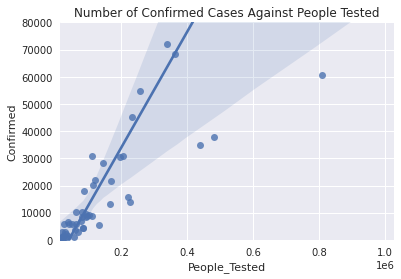

In [13]:
# To see whether or not positive correlations exist (to confirm our observations above)
# between the testing, hospitalisation, and the confirmed number of cases in a state
# (which we are trying to predict), we made the following scatterplots and calculated
# correlations between the variables.

# First, we visualised The number of confirmed cases against tested cases.

sns.regplot(states['People_Tested'], states['Confirmed'])
sns.set(rc = {'figure.figsize':(8, 6)})
plt.title('Number of Confirmed Cases Against People Tested')
plt.ylim(0, 80000)

# Calculate Pearson's correlation
corr, _ = pearsonr(states['Confirmed'], states['People_Tested'])
print('Pearsons correlation: %.3f' % corr)

# The plot shows a definite and high positive correlation in the beginning, 
# but there is a downwards incline/kink past 20,000 cases where the dots
# disperse, after which new cases grow more slowly with higher testing.

Pearsons correlation: 0.785


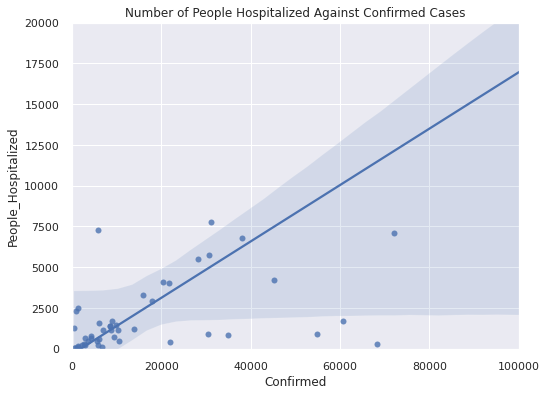

In [14]:
# Next, we visualised the number of people hospitalised against confirmed cases.

sns.regplot(states['Confirmed'], states['People_Hospitalized'])
sns.set(rc = {'figure.figsize':(8, 6)})
plt.title('Number of People Hospitalized Against Confirmed Cases')
plt.xlim(0, 100000)
plt.ylim(0, 20000)

# Calculate Pearson's correlation
corr, _ = pearsonr(states['Confirmed'], states['People_Hospitalized'])
print('Pearsons correlation: %.3f' % corr)

# There is a high positive correlation here which tells us that there will
# almost certainly be a point at which hospitals are unable to take more patients
# if confirmed cases keep rising. The high number of confirmed cases at the bottom 
# show states with no hospital data.

In [0]:
# Next, we will analyse the timeseries data on COVID-19 confirmed cases, deaths, 
# and recoveries. To visualise trend over time, we cleaned the data by 
# dropping unused columns and melting the dataframe to reflect a column for date
# and the corresponding cumulative values for cases, deaths and recoveries per 
# country. After that, we joined the relevant columns to make a single table.

confirmed_global = clean_timeseries(confirmed_global, 'Country/Region', 'Confirmed', 
                                           ['Lat', 'Long', 'Province/State'])
deaths_global = clean_timeseries(deaths_global, 'Country/Region', 'Deaths', 
                                        ['Lat', 'Long', 'Province/State'])
recovered_global = clean_timeseries(recovered_global, 'Country/Region', 'Recovered', 
                                           ['Lat', 'Long', 'Province/State'])

global_data = confirmed_global.merge(deaths_global, on = ['Country/Region', 
          'Date']).merge(recovered_global, on = ['Country/Region', 'Date'])

In [0]:
# We the get a value for the total number of confirmed cases
# in each unique country/region of the dataframe by 5/9/2020.

dates = list(global_data['Date'].unique())
latest_confirmed = select_rows(global_data, 'Date', dates[-1])['Confirmed']
unique_countries = list(global_data['Country/Region'].unique())

total_confirmed_cases = []
no_cases = []
for i in unique_countries:
    cases = latest_confirmed[global_data['Country/Region'] == i].sum()
    if cases > 0:
        total_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
unique_countries = [k for k, v in sorted(zip(unique_countries, total_confirmed_cases), 
                key = operator.itemgetter(1), reverse = True)]

for i in range(len(unique_countries)):
    total_confirmed_cases[i] = latest_confirmed[global_data['Country/Region'] ==
    unique_countries[i]].sum()

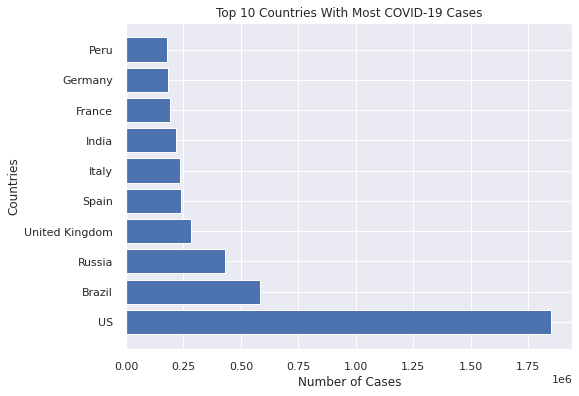

In [17]:
# Using the above data, we find the 10 countries in the world with the most 
# cases and plot them on a horizontal bar chart.

top10_countries = []
top10_cases = []

for i in range(len(total_confirmed_cases[:10])):
    top10_countries.append(unique_countries[i])
    top10_cases.append(total_confirmed_cases[i])

plt.barh(top10_countries, top10_cases)
plt.title('Top 10 Countries With Most COVID-19 Cases')
plt.xlabel('Number of Cases')
plt.ylabel('Countries')
plt.show()

In [18]:
# The graph shows how the total confirmed cases, deaths, and recoveries have
# changed over time in the US. All 3 seem to be increasing in an exponential
# manner, with the number of cases rising much more quickly than deaths or
# recoveries, indicating that there are likely still a lot of active cases.

us_data = select_rows(global_data, 'Country/Region', 'US')

fig = go.Figure()
fig.add_trace(go.Scatter(x = us_data['Date'], y = us_data['Confirmed'], mode = 'lines+markers',
             name = 'Total Cases'))
fig.add_trace(go.Scatter(x = us_data['Date'], y = us_data['Deaths'], 
              mode = 'lines+markers', name = 'Deaths', line = dict(color = 'Red', 
              width = 2)))
fig.add_trace(go.Scatter(x = us_data['Date'], y = us_data['Recovered'], 
              mode ='lines+markers', name = 'Recoveries', line = dict(width = 2)))
fig.update_layout(title_text = 'Trend of Coronavirus Cases in USA (Cumulative)', 
              plot_bgcolor= 'rgb(230, 230, 230)', xaxis_title = "Date",
              yaxis_title = "Number of Cases/Deaths/Recoveries")

In [19]:
# The graph shows how the total confirmed cases, deaths, and recoveries have
# changed over time in Spain. We looked at Spain in specific because it 
# has the second largest number of confirmed cases in the world despite have a much
# smaller population than other infected countries such as China or the US (which has
# the most cases), and they have been actively testing potential patients so the data
# is more reliable than that of under-tested countries like India. The trend for 
# all 3 lines is very similar to the US graph initially,
# where we can observe an exponential increase. It seems that growth has slowed around
# 200,000 cases and the line for total cases and deaths have begun to plateau as
# recoveries continue to increase. The smaller gap between deaths/recoveries and
# confirmed cases seem to indicate that a much fewer proportion of the cases are still
# active than in the US.

spain_data = select_rows(global_data, 'Country/Region', 'Spain')

fig = go.Figure()
fig.add_trace(go.Scatter(x = spain_data['Date'], y = spain_data['Confirmed'], 
            mode = 'lines+markers', name = 'Total Cases'))
fig.add_trace(go.Scatter(x = spain_data['Date'], y = spain_data['Deaths'], 
            mode = 'lines+markers', name = 'Deaths', line = dict(color = 'Red', 
            width = 2)))
fig.add_trace(go.Scatter(x = spain_data['Date'], y = spain_data['Recovered'], 
            mode = 'lines+markers', name = 'Recoveries', line = dict(width = 2)))
fig.update_layout(title_text = 'Trend of Coronavirus Cases in Spain (Cumulative)',
            plot_bgcolor = 'rgb(230, 230, 230)', xaxis_title = "Date",
              yaxis_title = "Number of Cases/Deaths/Recoveries")

In [20]:
# The graph shows how the total confirmed cases, deaths, and recoveries have
# changed over time in China. We looked at China in specific because it 
# was the first country to detect cases and now has widespread testing, giving us
# a presumably accurate picture of a potential course the virus may take over time. 
# The trend for all 3 lines is very similar to the US graph initially'
# where we can observe an exponential increase. It seems that growth has slowed around
# 80,000 cases and all 3 lines have reached plateau points.
# The smaller gap between deaths/recoveries and confirmed cases seem to indicate 
# that a much fewer proportion of the cases are still active than in the US and
# Spain. It's interesting that China was able to control the pandemic's growth 
# by the time 80,000 cases were confirmed despite having a much larger population
# than both Spain (where this effect was achieved after 200,000 cases) and the US
# (which already has over 1.3 million cases and growth seems to not be slowing down).

china_data = select_rows(global_data, 'Country/Region', 'China')

fig = go.Figure()
fig.add_trace(go.Scatter(x = china_data['Date'], y = china_data['Confirmed'], 
            mode = 'lines+markers', name = 'Total Cases'))
fig.add_trace(go.Scatter(x = china_data['Date'], y = china_data['Deaths'], 
            mode = 'lines+markers', name = 'Deaths', line = dict(color = 'Red', 
            width = 2)))
fig.add_trace(go.Scatter(x = china_data['Date'], y = china_data['Recovered'], 
            mode = 'lines+markers', name = 'Recoveries', line = dict(width = 2)))
fig.update_layout(title_text = 'Trend of Coronavirus Cases in China (Cumulative)',
            plot_bgcolor = 'rgb(230, 230, 230)', xaxis_title = "Date",
              yaxis_title = "Number of Cases/Deaths/Recoveries")

In [21]:
# These bar plots are a direct comparison between the growth and number of
# COVID-19 cases in China, Spain and the US over time. 
# From these comparisons we can deduce than population size of a country has 
# little role to play in the extend of the spread of COVID-19. We did not think it was 
# worthwhile to predict cases in the US on the basis of how the pandemic has
# aged in other countries due to the existence of multiple confounding factors such
# as technology, access to testing, policy, policy-enforecement, etc.

fig = make_subplots(rows = 2, cols = 2, specs = [[{}, {}], [{"colspan": 2}, None]],
    subplot_titles = ("China","Spain", "US"))

fig.add_trace(go.Bar(x = china_data['Date'], y = china_data['Confirmed'],
marker = dict(color = china_data['Confirmed'], coloraxis = "coloraxis")), 1, 1)

fig.add_trace(go.Bar(x = spain_data['Date'], y = spain_data['Confirmed'],
marker = dict(color = spain_data['Confirmed'], coloraxis = "coloraxis")), 1, 2)

fig.add_trace(go.Bar(x = us_data['Date'], y = us_data['Confirmed'],
marker = dict(color = us_data['Confirmed'], coloraxis = "coloraxis")), 2, 1)

fig.update_layout(coloraxis = dict(colorscale = 'Bluered_r'), showlegend = False,
title_text = "Total Confirmed Confirmed Cases Over Time")

fig.update_layout(plot_bgcolor = 'rgb(230, 230, 230)', xaxis_title = "Date",
              yaxis_title = "Number of Cases")
fig.show()

In [0]:
# The next dataframe we wanted to clean and examine to see if it provided
# useful information for developing features for our prediction model was the
# counties data. We dropped unnecessary columns, cosmetically renamed some
# other columns. We removed null values in 'States' by mapping state names from
# their corresponding abbreviations, and the other nulls through interpolation.

counties = counties.drop(['countyFIPS', 'STATEFP', 'COUNTYFP', 'lat', 'lon', 'POP_LATITUDE', 
               'POP_LONGITUDE', 'CensusRegionName', 'CensusDivisionName', 'Rural-UrbanContinuumCode2013', 'FracMale2017',
               'CensusPopulation2010', 'MedianAge2010', '#FTEHospitalTotal2017',
               "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017',
               'PopMale<52010', 'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010',
               'PopMale10-142010', 'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
               'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
                'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
                'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
                'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
                'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
                'PopFmle65-742010', 'PopMale75-842010', 'PopFmle75-842010',
               '3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge1-4Years2015-17', 
               '3-YrMortalityAge5-14Years2015-17', '3-YrMortalityAge15-24Years2015-17',
               '3-YrMortalityAge25-34Years2015-17', '3-YrMortalityAge35-44Years2015-17',
                '3-YrMortalityAge45-54Years2015-17', '3-YrMortalityAge55-64Years2015-17',
               'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop', 'PopTotalMale2017',
                'PopTotalFemale2017', '3-YrDiabetes2015-17', 'dem_to_rep_ratio',
                  'PopMale>842010', 'PopFmle>842010', '3-YrMortalityAge65-74Years2015-17',
                   '3-YrMortalityAge75-84Years2015-17','3-YrMortalityAge85+Years2015-17',
              'mortality2015-17Estimated'], axis = 1).rename(columns = {'PopulationEstimate65+2017':
              '65+ Population', 'MedicareEnrollment,AgedTot2017': 'MedicareEnrollment',
                'RespMortalityRate2014': 'RespMortality'})

assign_states(counties, 'StateName', 'State')      

for state in counties['StateName']:
    if not (state in state_abbrev.keys()):
        counties = remove_rows(counties, 'StateName', state)

counties = counties.reset_index(drop = True).interpolate()
counties_ny = select_rows(counties, 'State', 'New York')

In [0]:
# Cleaning US timeseries data to get confirmed cases and deaths per county
# and cosmetic renaming, then merging with cleaned counties data.

deaths_us = clean_timeseries(deaths_us, 'Province_State', 'Deaths', ['UID', 'iso2', 'iso3', 'code3',
  'FIPS', 'Lat', 'Long_', 'Combined_Key', 'Population'])
confirmed_us = clean_timeseries(confirmed_us, 'Province_State', 'Confirmed', ['UID', 'iso2', 'iso3', 'code3',
  'FIPS', 'Lat', 'Long_', 'Combined_Key'])
merged_state_data = confirmed_us.merge(deaths_us, on = ['Province_State', 'Date'])

Text(0, 0.5, 'Number of Deaths')

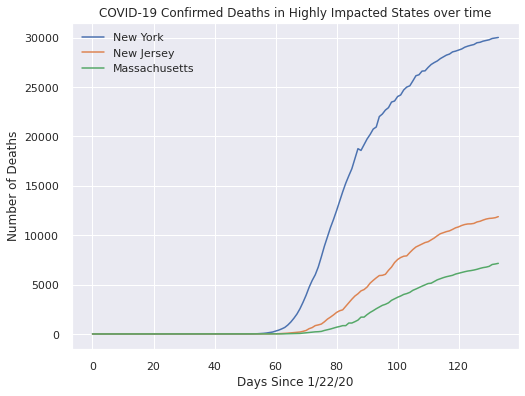

In [24]:
# Visualising the deaths in NY, NJ and CA over time
# as it was previously established that they were most impacted by the virus.

merged_data_ny = select_rows(merged_state_data, 'Province_State', 'New York')
merged_data_ny['Days After 01/22/2020'] = np.arange(len(merged_data_ny.index))

merged_data_nj = select_rows(merged_state_data, 'Province_State', 'New Jersey')
merged_data_nj['Days After 01/22/2020'] = np.arange(len(merged_data_nj.index))

merged_data_ma = select_rows(merged_state_data, 'Province_State', 'Massachusetts')
merged_data_ma['Days After 01/22/2020'] = np.arange(len(merged_data_ma.index))

sns.lineplot(x = 'Days After 01/22/2020', y = 'Deaths', data = merged_data_ny)
sns.lineplot(x = 'Days After 01/22/2020', y = 'Deaths', data = merged_data_nj)
sns.lineplot(x = 'Days After 01/22/2020', y = 'Deaths', data = merged_data_ma)

plt.legend(['New York', 'New Jersey', 'Massachusetts'])
plt.title('COVID-19 Confirmed Deaths in Highly Impacted States over time')
plt.xlabel('Days Since 1/22/20')
plt.ylabel('Number of Deaths')

Text(0, 0.5, 'Number of Cases')

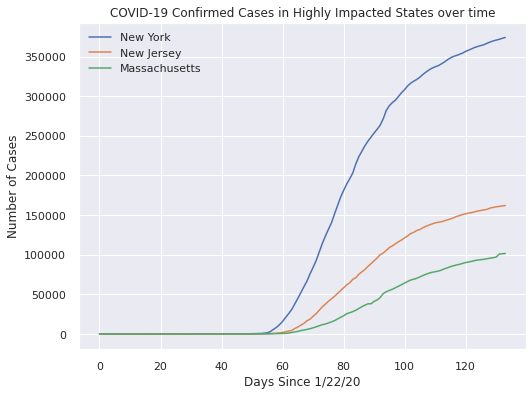

In [25]:
# Visualising the confirmed cases in NY, NJ and MA over time
# as it was previously established that they were most impacted by the virus.

sns.lineplot(x = 'Days After 01/22/2020', y = 'Confirmed', data = merged_data_ny)
sns.lineplot(x = 'Days After 01/22/2020', y = 'Confirmed', data = merged_data_nj)
sns.lineplot(x = 'Days After 01/22/2020', y = 'Confirmed', data = merged_data_ma)

plt.legend(['New York', 'New Jersey', 'Massachusetts'])
plt.title('COVID-19 Confirmed Cases in Highly Impacted States over time')
plt.xlabel('Days Since 1/22/20')
plt.ylabel('Number of Cases')

In [0]:
# Aggregate county data into state data. Summed columns chosen on the basis of 
# data we need totals of (population based). Meaned chosen on the basis of traits that
# cannot be accurately summed (like proportions). Maxed data is the latest date
# state orders were implemented in teh county of a state.

summed = counties[['State', 'PopulationEstimate2018', '65+ Population', '#EligibleforMedicare2018', 'MedicareEnrollment',
                                   '#Hospitals', '#ICU_beds']].groupby('State').sum()

meaned = counties[['State', 'PopulationDensityperSqMile2010', 'DiabetesPercentage',
       'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage',
       'RespMortality', 'SVIPercentile']].groupby('State').mean()

maxed = counties[['State', 'stay at home',
       '>50 gatherings', '>500 gatherings', 'public schools',
       'restaurant dine-in', 'entertainment/gym', 'federal guidelines',
       'foreign travel ban']].groupby('State').max()

summed_and_meaned = summed.merge(meaned, on = 'State').reset_index()
state_data = summed_and_meaned.merge(maxed, on = 'State').reset_index(drop = True)

In [0]:
# Format the dates in the state data to be easier to work with and
# to reflect days since 01/22/2020.

state_data = format_dates(state_data, ['stay at home', '>50 gatherings', '>500 gatherings', 
            'public schools', 'restaurant dine-in', 'entertainment/gym', 'federal guidelines', 'foreign travel ban'])
state_data = days_since(state_data, ['stay at home', '>50 gatherings', '>500 gatherings', 
  'public schools', 'restaurant dine-in', 'entertainment/gym', 'federal guidelines', 'foreign travel ban'])

In [0]:
# Combining NY data from both dataframes.

state_data_ny = select_rows(state_data, 'State', 'New York')
merged_data_ny = merged_data_ny.rename(columns = {'Province_State': 'State'})
all_data_ny = state_data_ny.merge(merged_data_ny, on = 'State').drop(['State', 'Date'], axis = 1)

In [0]:
# Using linear regression model for predicting deaths in NY State.

X = all_data_ny[['Confirmed']]
Y = all_data_ny['Deaths']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, shuffle = False)
linear_model = lm.LinearRegression(fit_intercept = True)
linear_model.fit(x_train, y_train)
y_predicted = linear_model.predict(x_train)

In [30]:
# Calculating rmse on training and testing data

train_rmse = rmse(y_predicted, y_train)
test_rmse = rmse(linear_model.predict(x_test), y_test)
print(f"Training RMSE: {train_rmse}", f"Testing RMSE: {test_rmse}")

Training RMSE: 886.2943019293408 Testing RMSE: 1784.1954482455894


In [31]:
# Assesses accuracy of the model on train and test data

train_error = r2_score(y_pred = y_predicted, y_true = y_train)
test_error = r2_score(y_pred = linear_model.predict(x_test), y_true = y_test)
print(f"Training R2 Score: {train_error}", f"Testing R2 Score: {test_error}")

Training R2 Score: 0.9867616756079366 Testing R2 Score: -0.004543573288876113


In [0]:
# Function for the model defined above

def model(x_data, test_sze = 0.25, randomize = False):
    """ Computes y_predicted for the given linear model. """
    X = all_data_ny[x_data]
    Y = all_data_ny['Deaths']
    x_train, x_test, y_train, y_test = train_test_split(X, Y, 
        test_size = test_sze, shuffle = False)
    linear_model = lm.LinearRegression(fit_intercept = True)
    linear_model.fit(x_train, y_train)
    y_predicted_train= linear_model.predict(x_train)
    y_predicted_test = linear_model.predict(x_test)
    return [y_predicted_train, y_train]

In [0]:
# Keeps track of RMSEs and R2 scores for each feature added.

relevant_columns = ['PopulationEstimate2018', '65+ Population',
       '#EligibleforMedicare2018', 'MedicareEnrollment', '#Hospitals',
       '#ICU_beds', 'PopulationDensityperSqMile2010', 'DiabetesPercentage',
       'HeartDiseaseMortality', 'StrokeMortality', 'Smokers_Percentage',
       'RespMortality', 'SVIPercentile', 'stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'federal guidelines', 'foreign travel ban',
       'Confirmed', 'Deaths', 'Days After 01/22/2020']
rmses = [train_rmse]
r2_scores = [train_error]
for i in range(1, 24):
    y_preds = model(relevant_columns[0: i])
    rmses.append(rmse(y_preds[0], y_preds[1]))
    r2_scores.append(r2_score(y_preds[0], y_preds[1]))

In [34]:
# Our goal is to lower RMSE and increase r2_score.

error_data = pd.DataFrame({'Feature_Add': relevant_columns,
                          'RMSE': rmses,
                          'r2_score': r2_scores})
error_data

,Feature_Add,RMSE,r2_score
0,PopulationEstimate2018,8.862943e+02,9.867617e-01
1,65+ Population,7.703027e+03,-1.793340e+31
2,#EligibleforMedicare2018,7.703027e+03,-1.793340e+31
3,MedicareEnrollment,7.703027e+03,-1.793340e+31
4,#Hospitals,7.703027e+03,-1.793340e+31
5,#ICU_beds,7.703027e+03,-1.793340e+31
6,PopulationDensityperSqMile2010,7.703027e+03,-1.793340e+31
7,DiabetesPercentage,7.703027e+03,-1.793340e+31
8,HeartDiseaseMortality,7.703027e+03,-7.173359e+31
9,StrokeMortality,7.703027e+03,-1.793340e+31


(array([-1.  , -0.75, -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ]),
 <a list of 9 Text major ticklabel objects>)

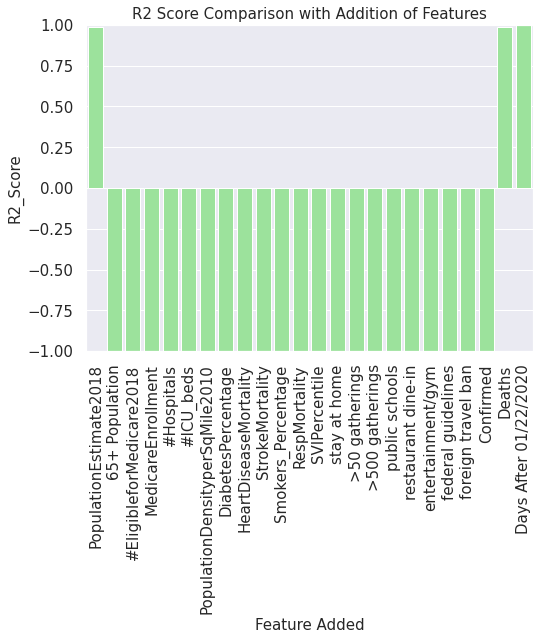

In [35]:
# The inital'Confirmed' r2_score acts as a baseline value to compare other r2_scores
# with the addition of more features.
# The r2_score increased when using other features.

sns.barplot(x = 'Feature_Add', y = 'r2_score', data = error_data, color = 'lightgreen')
plt.ylim(-1, 1)
plt.xticks(rotation = 90)
plt.title('R2 Score Comparison with Addition of Features', size = 15)
plt.xlabel('Feature Added', size = 15)
plt.ylabel('R2_Score', size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)

Text(0.5, 1.0, 'RMSE Comparison with Addition of Features')

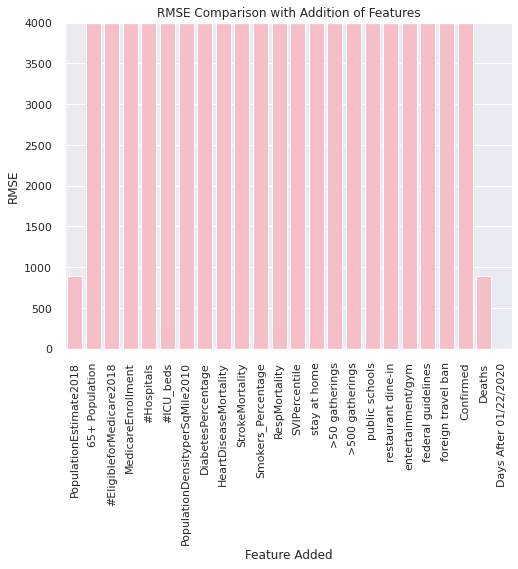

In [36]:
# RMSE increases with the addition of most features.

sns.barplot(x = 'Feature_Add', y = 'RMSE', data = error_data, color = 'lightpink')
plt.xticks(rotation = 90)
plt.ylim(0, 4000)
plt.xlabel('Feature Added')
plt.ylabel('RMSE')
plt.title('RMSE Comparison with Addition of Features')

In [0]:
# Adding features that can't change over a short period of 109 days
# did not help the model. The model should only be based on confirmed cases
# and deaths

some_data_ny = all_data_ny[['Confirmed', 'Days After 01/22/2020', 'Deaths']]
x_train, x_test, y_train, y_test = train_test_split(np.array(some_data_ny['Confirmed']).reshape(-1, 1),
np.array(some_data_ny['Deaths']).reshape(-1, 1), test_size = 0.15, shuffle = False)
linear_model = LinearRegression(normalize = True, fit_intercept = True)
linear_model.fit(x_train, y_train)
test_linear_pred = linear_model.predict(x_test)
train_linear_pred = linear_model.predict(x_train)

In [38]:
# Calculates training and testing rmse scores.

train_rmse = rmse(train_linear_pred, y_train)
test_rmse = rmse(test_linear_pred, y_test)
print(f"Training RMSE: {train_rmse}", f"Testing RMSE: {test_rmse}")

Training RMSE: 904.144719176157 Testing RMSE: 1204.3196247640624


In [39]:
# Assesses accuracy of the model on train and test data. The improvement in
# our accuracy metrics show us that our conclusion was correct and removing extra 
# features has improved our model.

train_error = r2_score(y_pred = train_linear_pred, y_true = y_train)
test_error = r2_score(y_pred = test_linear_pred, y_true = y_test)
print(f"Training R2 Score: {train_error}", f"Testing R2 Score: {test_error}")

Training R2 Score: 0.991672639834181 Testing R2 Score: -1.9116546616842762


In [0]:
# To predict cases 10 days into the future.

days_in_future = 10
future_forecast = np.array([i for i in range(len(dates) + days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forecast[: -10]
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forecast_dates = []
for i in range(len(future_forecast)):
    future_forecast_dates.append((start_date + datetime.timedelta(days = i)).strftime('%m/%d/%Y'))

In [0]:
# Instead of testing features that we know will overtrain and overfit our 
# model for prediction of confirmed cases in the future, we will use only time.

x_train, x_test, y_train, y_test = train_test_split(np.array(some_data_ny['Days After 01/22/2020']).reshape(-1, 1),
np.array(some_data_ny['Confirmed']).reshape(-1, 1), test_size = 0.15, shuffle = False)
linear_model = LinearRegression(normalize = True, fit_intercept = True)
linear_model.fit(x_train, y_train)
test_linear_pred = linear_model.predict(x_test)
train_linear_pred = linear_model.predict(x_train)
future_pred_linear = linear_model.predict(future_forecast)

In [42]:
# Calculates training and testing rmse scores.

train_rmse = rmse(train_linear_pred, y_train)
test_rmse = rmse(test_linear_pred, y_test)
print(f"Training RMSE: {train_rmse}", f"Testing RMSE: {test_rmse}")

Training RMSE: 57157.363640347976 Testing RMSE: 35592.368791618916


(array([280000., 290000., 300000., 310000., 320000., 330000., 340000.,
        350000., 360000., 370000., 380000.]),
 <a list of 11 Text major ticklabel objects>)

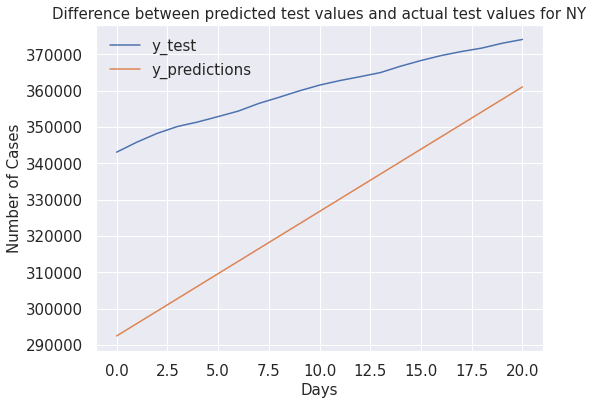

In [43]:
# Plotting the difference between our predicted test values and the actual test values
y_test, = plt.plot(y_test, label = 'y_test')
y_predictions, = plt.plot(test_linear_pred, label = 'y_predictions')
plt.title('Difference between predicted test values and actual test values for NY', size = 15)
plt.xlabel('Days', size = 15)
plt.ylabel('Number of Cases', size = 15)
plt.xticks(size = 15)
plt.legend(handles = [y_test, y_predictions], prop = {'size': 15})
plt.yticks(size = 15)

[]

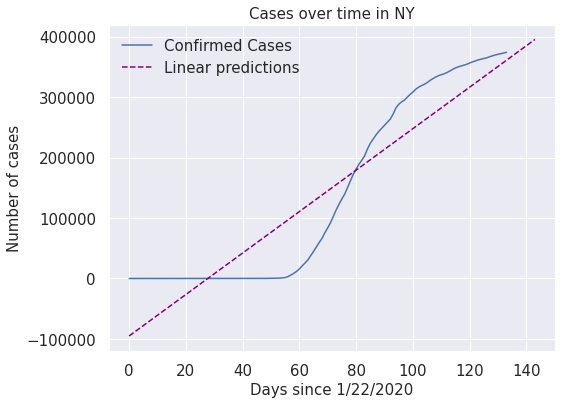

In [44]:
# Plotting our model's predictions for cases  over time with actual cases over time.

plt.plot(np.array(some_data_ny['Days After 01/22/2020']), np.array(some_data_ny['Confirmed']))
plt.plot(future_forecast, future_pred_linear, linestyle = 'dashed', color = 'purple')
plt.title('Cases over time in NY', size = 15)
plt.xlabel('Days since 1/22/2020', size = 15)
plt.ylabel('Number of cases', size = 15)
plt.legend(['Confirmed Cases', 'Linear predictions'], prop = {'size' : '15'})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot()

In [45]:
# It seems like our model was unable to follow a trend for exponential predictions.
# Here are some predictions for number of new cases in the next 10 days per day.

print('Linear Future Predictions:')
total = [j for i in list(future_pred_linear[-11:].reshape(-1, 1)) for j in i]
total_new = [total[i] - total[i - 1] for i in range(len(total))][1:]
print(total_new)

Linear Future Predictions:
[3429.316280191648, 3429.316280191648, 3429.3162801915896, 3429.316280191648, 3429.316280191648, 3429.3162801915896, 3429.316280191648, 3429.316280191648, 3429.3162801915896, 3429.316280191648]


In [46]:
# Getting the hospitalisation rate for NY state. We assume this is an average
# value for all counties and doesn't change over a short period of time.

hos_rate = list(select_rows(states, 'State', 'New York')['Hospitalization_Rate'])[0]
hos_rate

21.772774694578022

In [0]:
# Appended predicted values to dataframe

last_day = list(some_data_ny['Days After 01/22/2020'])[-1]
last_cases = list(some_data_ny['Confirmed'])[-1]
new_pred = pd.DataFrame({'Days After 01/22/2020': [i + last_day for i in range(1, 11)],
                          'Confirmed': total_new})
new_pred['Confirmed'] = new_pred['Confirmed'].cumsum() + last_cases

In [0]:
# Appended predicted values to dataframe

some_data_ny = some_data_ny.append(new_pred)

In [0]:
# Find number of hospital beds in NY, assuming the information
# doesn't change quickly.

hospital_beds = hospital_beds.rename(columns = {'location_name': 'location'})

for place in list(hospital_beds['location']):
    if place in states_list:
        hospital_beds = hospital_beds
    else:
        hospital_beds = remove_rows(hospital_beds, 'location', place)

hospital_beds.drop(hospital_beds.columns.difference(['location',
            'all_bed_capacity']), 1, inplace = True)

In [0]:
# Finding the total number of hospital beds in NY.

hospital_beds_ny = list(select_rows(hospital_beds,
                                    'location', 'New York')['all_bed_capacity'])[0]

In [51]:
# Visualising how increasing hospitalisations (which we get from multiplying 
# the hospitalisation rate calculated above with existing data as well as future predictions)
# compare to the capacity of NY's medical resources in terms of hospital beds.
# We assume that hospitalisation implies that patients are given a bed (staffed or 
# unstaffed) and that recoveries/deaths do not largely impact the value of
# hospitalisations as many of them (especially recoveries) happen in homes.
# We also assume that all beds are being used by COVID patients for simplicity
# of calculation, so our prediction for available beds may well be an overestimate.

some_data_ny = some_data_ny.sort_values(by = 'Days After 01/22/2020')
some_data_ny['Daily Confirmed Hospitalisations'] = some_data_ny[
    'Confirmed'].diff() * (hos_rate / 100)
some_data_ny['Total Hospitalisations'] = some_data_ny['Confirmed'] *  (hos_rate / 100)
fig = px.bar(some_data_ny, x = 'Days After 01/22/2020',
             y = 'Daily Confirmed Hospitalisations', height = 400)
fig.add_trace(go.Scatter(x = some_data_ny['Days After 01/22/2020'],
                         y = some_data_ny['Total Hospitalisations'], 
            mode = 'lines+markers', name = 'Total Hospitalisations'))
fig.add_shape(dict(type = "line",x0 = '0', y0 = hospital_beds_ny, 
                   x1 = '120', y1 = hospital_beds_ny, line = dict(color = "Red",
width = 1, dash = "dot")))
fig.add_trace(go.Scatter(x = ['130', '130'] , y = [hospital_beds_ny], text = ["Beds"],
mode = "text", name = "Total Hospital Beds NY"))
fig.update_layout(title_text = 'Increase in Coronavirus Hospitalisations in NY',
                  plot_bgcolor = 'rgb(250, 250, 250)')
fig.show()

In [52]:
# Plotting the predicted deficit in hospital beds.

some_data_ny['Hospital Beds Needed'] = some_data_ny['Total Hospitalisations'] - hospital_beds_ny
fig = px.bar(some_data_ny, x = 'Days After 01/22/2020', y = 'Hospital Beds Needed', height = 400)
fig.update_layout(title_text = 'Total Hospital Beds Needed in NY', plot_bgcolor = 
                  'rgb(250, 250, 250)')
fig.show()

In [0]:
# Our linear model is not the best for predicting the number of growing cases in 
# NY because the growth of the virus clearly follows a sigmoid-like trend
# as is characteristic of most pandemics. It would be more useful to use a model
# that could fit to a sigmoid shape like perhaps svm that may increase accuracy.
# Going off of our current model, we can see that the number of hospitalisations
# has exceeded capacity by day 95 by almost 500 beds.

x_train, x_test, y_train, y_test = train_test_split(np.array(some_data_ny['Days After 01/22/2020']).reshape(-1, 1),
np.array(some_data_ny['Confirmed']).reshape(-1, 1), test_size = 0.15, shuffle = False)
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10]
gamma = [0.01, 0.1, 1]
epsilon =[0.01, 0.1, 1]
shrinking = [True, False]
svm_grid = {'kernel':kernel, 'C': c, 'gamma': gamma, 'epsilon': epsilon, 'shrinking': shrinking}
svm = SVR()
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv = 3, return_train_score = True,
n_jobs = -1, n_iter = 40, verbose = 1)
svm_search.fit(x_train, y_train)

In [0]:
svm_search.best_params_

In [0]:
svm_confirmed = svm_search.best_estimator_
svm_pred = svm_confirmed.predict(future_forecast)
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(svm_test_pred)
plt.plot(y_test_confirmed)
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:', mean_squared_error(svm_test_pred, y_test_confirmed))
print('RMSE:', np.sqrt(mean_squared_error(svm_test_pred, y_test_confirmed)))

In [0]:
# Plotting our model's predictions for cases  over time with actual cases over time.
# It seems like our SVM model is over-estimating the most recent number of cases.

plt.plot(np.array(some_data_ny['Days After 01/22/2020']), np.array(some_data_ny['Confirmed']))
plt.plot(future_forecast, svm_pred, linestyle = 'dashed', color = 'purple')
plt.title('Cases over time in NY', size = 15)
plt.xlabel('Days since 1/22/2020', size = 15)
plt.ylabel('Number of cases', size = 15)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop = {'size' : '15'})
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.plot()